In [178]:
!pip install yahoofinancials

In [179]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [180]:
# Download and load data
df = yf.download('AMZN',
                 start='2018-05-27',
                 end='2023-05-26',
                 progress=False)
df.to_csv('AMZN.csv')
df = pd.read_csv('AMZN.csv')

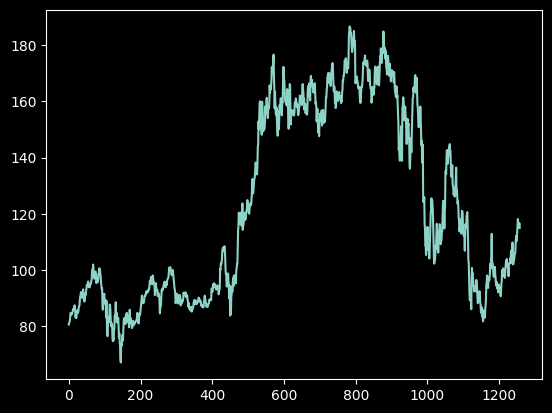

In [181]:
close_prices =df.reset_index()['Close']
plt.plot(close_prices )

In [182]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices  = scaler.fit_transform(np.array(close_prices ).reshape(-1,1))

In [183]:
# Split data into train and test sets
training_size = int(len(close_prices ) * 0.65)
test_size = len(close_prices ) - training_size
train_data, test_data = close_prices [0:training_size, :], close_prices [training_size:len(close_prices ), :]

In [184]:
# Function to create dataset
def pre_processing_data(dataset, time_step=1):
    features, labels = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        features.append(a)
        labels.append(dataset[i + time_step, 0])
    return np.array(features), np.array(labels)

In [185]:
time_step = 100
X_train, y_train = pre_processing_data(train_data, time_step)
X_test, y_test = pre_processing_data(test_data, time_step)

In [186]:
# Reshape data for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [187]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=3):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out[:, -1, :].unsqueeze(1))  # take the last time step output from lstm1
        out, _ = self.lstm3(out[:, -1, :].unsqueeze(1))  # take the last time step output from lstm2
        out = self.linear(out[:, -1, :])
        return out

In [188]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
ytest_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [189]:
# Initialize model
model = LSTMModel()

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTMModel(
  (lstm1): LSTM(1, 50, num_layers=3, batch_first=True)
  (lstm2): LSTM(50, 50, num_layers=3, batch_first=True)
  (lstm3): LSTM(50, 50, num_layers=3, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [190]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Convert train and test data to tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 100, 1)
X_test_tensor = X_test_tensor.view(-1, 100, 1)

# Predictions for train and test sets
with torch.no_grad():
    y_train_pred = model(X_train_tensor)
    y_test_pred = model(X_test_tensor)

# Convert predictions to numpy arrays
y_train_pred = y_train_pred.numpy()
y_test_pred = y_test_pred.numpy()

# Inverse transform to original form
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))

# Calculate RMSE for train and test predictions
rmse_train = math.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = math.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'Train RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')

Epoch [10/100], Loss: 0.1113
Epoch [20/100], Loss: 0.0062
Epoch [30/100], Loss: 0.0019
Epoch [40/100], Loss: 0.0011
Epoch [50/100], Loss: 0.0023
Epoch [60/100], Loss: 0.0012
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0017
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0008
Train RMSE: 126.8212
Test RMSE: 120.3308


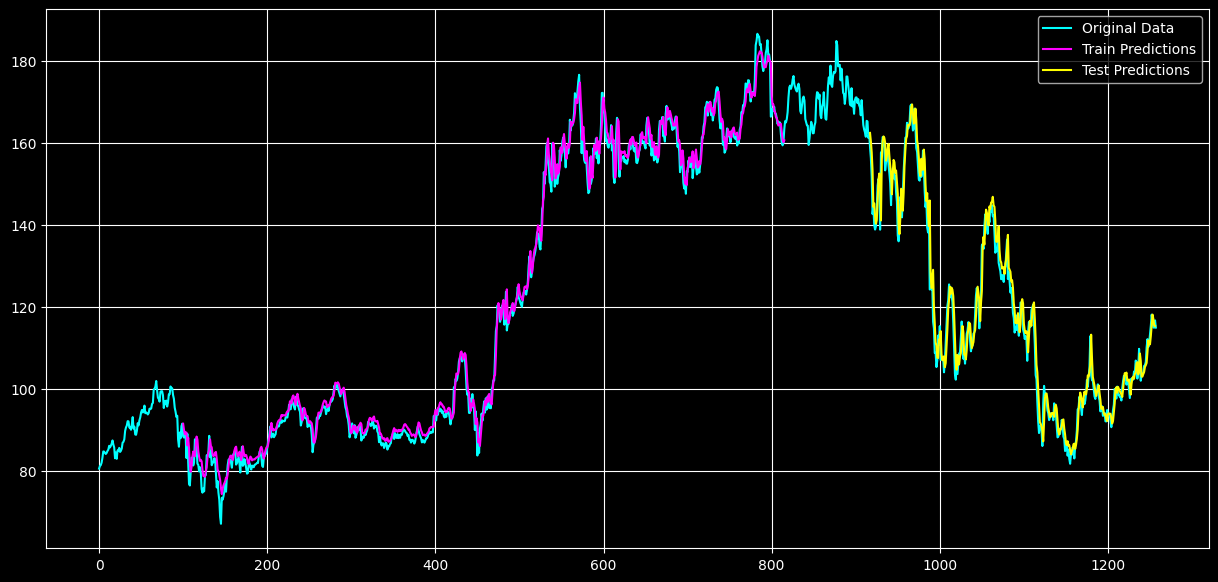

In [207]:
# Define a new window size
window_size = 100

# Initialize arrays for predictions
train_out = np.empty_like(close_prices )
train_out[:, :] = np.nan
train_out[window_size:len(y_train_pred)+window_size, :] = y_train_pred

test_out = np.empty_like(close_prices )
test_out[:, :] = np.nan
test_out[len(y_train_pred)+(window_size*2)+1:len(close_prices )-1, :] = y_test_pred

# Inverse transform to original scale
close_prices_scaled = scaler.inverse_transform(close_prices .reshape(-1, 1))

# Plot original data and predictions with different colors and background
plt.figure(figsize=(15, 7))
plt.style.use('dark_background')  # Change background to dark
plt.plot(close_prices_scaled, label='Original Data', color='cyan')
plt.plot(train_out, label='Train Predictions', color='magenta')
plt.plot(test_out, label='Test Predictions', color='yellow')
plt.legend()
plt.grid(True)
plt.show()


In [197]:
sample_input = test_data[341:].reshape(1, -1)
temp_input = sample_input.flatten().tolist()
# demonstrate prediction for next 10 days
predictions = []
i = 0
while i < 30:

    if len(temp_input) > 100:
        sample_input = np.array(temp_input[1:])

        # Convert numpy array to PyTorch tensor and reshape
        sample_input = torch.tensor(sample_input, dtype=torch.float32).view(1, -1)
        sample_input = sample_input.view(1, 100, 1)

        # Get prediction from the model
        with torch.no_grad():
            predicted_output = model(sample_input)

        # Convert prediction to list and extend temp_input
        temp_input.extend(predicted_output.numpy().flatten().tolist())
        temp_input = temp_input[1:]

        # Extend lst_output
        predictions.extend(predicted_output.numpy().tolist())

        i = i + 1
    else:
        # Convert temp_input to numpy array, reshape, and convert to tensor
        sample_input = np.array(temp_input).reshape(1, 100, 1)
        sample_input = torch.tensor(sample_input, dtype=torch.float32)

        # Get prediction from the model
        with torch.no_grad():
            predicted_output = model(sample_input)

        print(predicted_output.numpy()[0])

        # Convert prediction to list and extend temp_input
        temp_input.extend(predicted_output.numpy().flatten().tolist())

        # Extend lst_output
        predictions.extend(predicted_output.numpy().tolist())

        i = i + 1

[0.41161287]


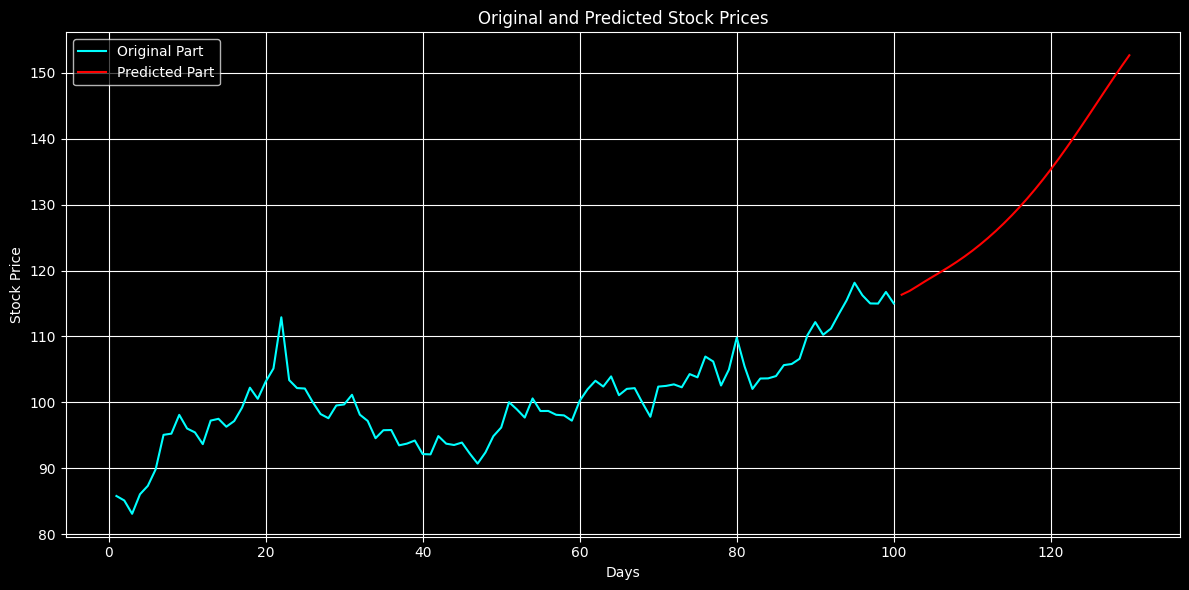

In [217]:
import matplotlib.pyplot as plt

days_original = np.arange(1, 101)
days_predicted = np.arange(101, 131)

plt.figure(figsize=(12, 6))
plt.plot(days_original, scaler.inverse_transform(close_prices[1158:]), label='Original Part', color='cyan')
plt.plot(days_predicted, scaler.inverse_transform(predictions), label='Predicted Part', color='red')

plt.title('Original and Predicted Stock Prices', color='white')
plt.xlabel('Days', color='white')
plt.ylabel('Stock Price', color='white')

plt.grid(True, color='white')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', fontsize=10, framealpha=0.7, labelcolor='white')

plt.tight_layout()
plt.show()


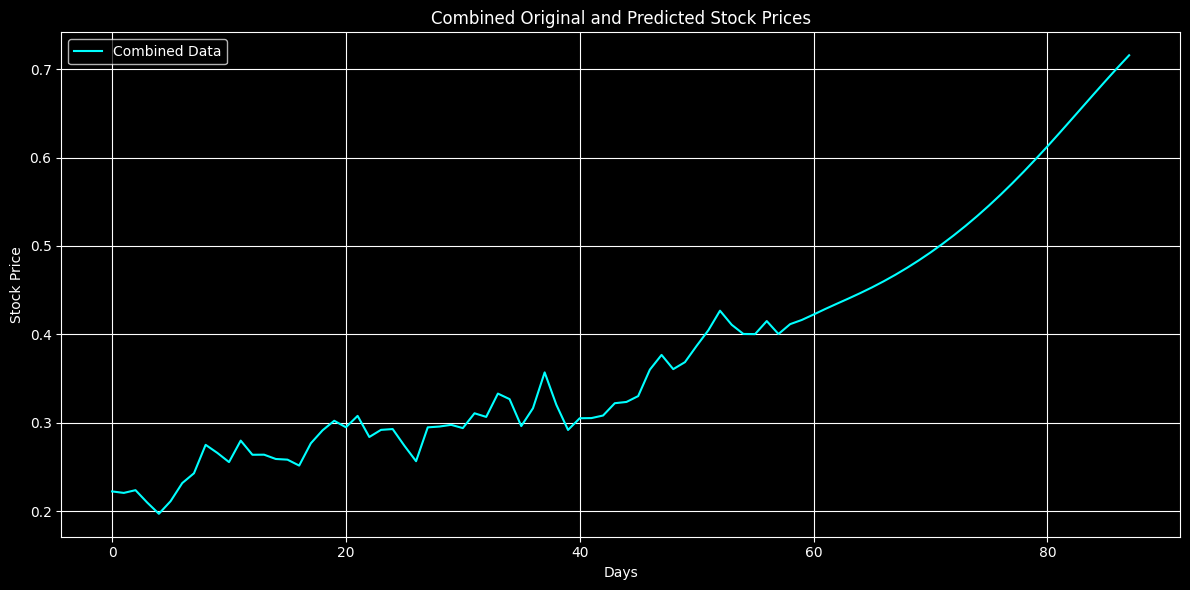

In [215]:
combined_data = close_prices.tolist()
combined_data.extend(predictions)

plt.figure(figsize=(12, 6))
plt.plot(combined_data[1200:], label='Combined Data', color='cyan')
plt.title('Combined Original and Predicted Stock Prices', color='white')
plt.xlabel('Days', color='white')
plt.ylabel('Stock Price', color='white')

plt.grid(True, color='white')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', fontsize=10, framealpha=0.7, labelcolor='white')

plt.tight_layout()
plt.show()


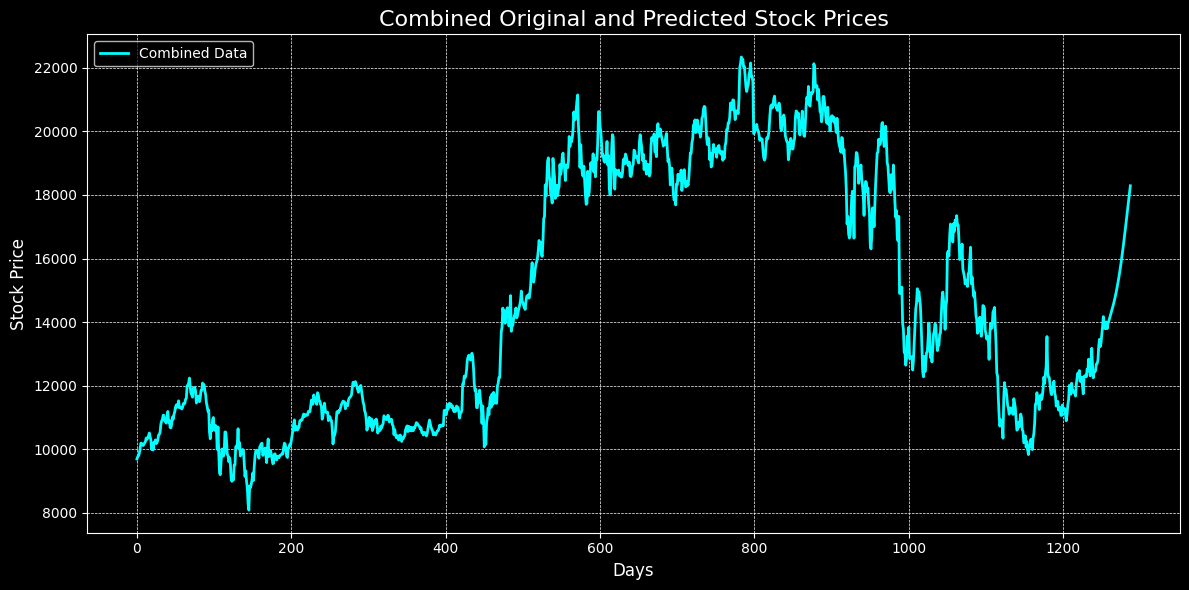

In [219]:
combined_data = scaler.inverse_transform(combined_data).tolist()

plt.figure(figsize=(12, 6))
plt.plot(combined_data, label='Combined Data', color='cyan', linewidth=2)

plt.title('Combined Original and Predicted Stock Prices', color='white', fontsize=16)
plt.xlabel('Days', color='white', fontsize=12)
plt.ylabel('Stock Price', color='white', fontsize=12)

plt.grid(True, color='white', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left', facecolor='black', edgecolor='white', fontsize=10, framealpha=0.7, labelcolor='white')

plt.tight_layout()
plt.show()